<a href="https://colab.research.google.com/github/jkaczmarski/variantplot/blob/main/VariantPlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Variant Plotter
# @markdown This notebook has been put together by Joe Kaczmarski to help generate figures showing different protein constructs, including glycosylation sites, substitution sites, protease cut-sites, truncations etc.


In [ ]:
# @title SETUP
# @markdown Run this cell to set-up the notebook.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os.path
from os import path
plt.rcParams['svg.fonttype'] = 'none'

if path.exists('output') == False:
  os.mkdir('output')

#DEFINE FUNCTIONS

def plotty(job_name,input_file):

    plt.rcParams['font.family'] = set_font

    def get_color_from_dictionary(fragment, default_color='grey'):
        for key, color in color_dictionary.items():
            if key in fragment:
                return color
        return default_color

    # Read protein variant information from an Excel spreadsheet
    data = pd.read_excel(input_file)

    # Split columns containing comma-separated values into lists (if substitutions columns contains valid strings)
    data['substitutions'] = data['substitutions'].apply(lambda x: x if isinstance(x, str) else '').str.split(',')

    # # Split label columns containing comma-separated values into lists (if columns contains valid strings)
    data['glyco_sites'] = data['glyco_sites'].apply(lambda x: x if isinstance(x, str) else '').str.split(',')

    if 'site_labels' in data.columns:
        data['site_labels'] = data['site_labels'].apply(lambda x: x if isinstance(x, str) else '').str.split(';')
    else:
        # Handle the case where 'site_labels' column is not present
        data['site_labels'] = None  # or any other default value


    if 'cut_sites' in data.columns:
        data['cut_sites'] = data['cut_sites'].apply(lambda x: x if isinstance(x, str) else '').str.split(';')
    else:
        # Handle the case where 'site_labels' column is not present
        data['cut_sites'] = None  # or any other default value


    # Check if the 'references' column contains valid string values before splitting it
    data['references'] = data['references'].apply(lambda x: x if isinstance(x, str) else '').str.split(',')

    # Ensure that "N-flank_size" and "C-flank_size" columns exist and provide default values
    data['N-flank_size'] = data['N-flank_size'].fillna(set_default_flank_size)
    data['C-flank_size'] = data['C-flank_size'].fillna(set_default_flank_size)

    # Split the 'N_flank' and 'C_flank' columns into lists of strings
    data['N-flank_names'] = data['N-flank_names'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
    data['C-flank_names'] = data['C-flank_names'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

    # Convert the data to a list of dictionaries
    protein_variants = data.to_dict(orient='records')

    # # Calculate the length of the longest list of strings in the N_flanks and C_flanks columns
    # max_n_flank_length = max(len(variant["N_flank"]) * variant["N-flank_size"] for variant in protein_variants)

    xstart=min([variant["start_residue"]-(len(variant["N-flank_names"]) * variant["N-flank_size"]) for variant in protein_variants])-left_pad
    xend=max([variant["end_residue"]+(len(variant["C-flank_names"]) * variant["C-flank_size"]) for variant in protein_variants])+right_pad

    def plot_protein_variant(ax, variant):
        start_residue = variant["start_residue"]
        end_residue = variant["end_residue"]
        mutations = variant["substitutions"]
        references = variant["references"]
        N_flanks = variant["N-flank_names"]  # List of N-flanks
        C_flanks = variant["C-flank_names"]  # List of C-flanks
        N_flank_size = variant["N-flank_size"]
        C_flank_size = variant["C-flank_size"]

        # Create a horizontal rectangle for the main primary structure
        ax.add_patch(plt.Rectangle((start_residue, 0), end_residue - start_residue, 1, facecolor=core_color, alpha=0.5, edgecolor=set_edge_color, lw=set_edge_thickness))

        # Label start and end residues as vertical lines with residue numbers
        ax.plot([start_residue, start_residue], [0, 1], color='black')
        ax.plot([end_residue, end_residue], [0, 1], color='black')
        ax.text(start_residue - 1, 0.1, str(start_residue), va='center', ha='right', fontsize=set_termini_size, fontweight='bold')
        ax.text(end_residue + 1, 0.1, str(end_residue), va='center', ha='left', fontsize=set_termini_size, fontweight='bold')

        # Add downward arrows and labels for start and end residues if they are not equal to 1 and fl_end, respectively
        if start_residue != 1:
            start_trunc=start_residue-1
            ax.annotate(f"▲\n"+f"Δ{fl_start}-{start_trunc}", (start_residue, 0), fontsize=set_truncation_size, fontname='DejaVu Sans', va='top', ha='center', color="red")

        if end_residue != fl_end:
            end_trunc=end_residue+1
            ax.annotate("▲\n"+f"Δ{end_trunc}-{fl_end}", (end_residue, 0), fontsize=set_truncation_size, fontname='DejaVu Sans', va='top', ha='center', color="red")


        # Check if mutations is a list and not NaN before sorting and processing it
        mutation_positions = []  # Initialize mutation_positions here
        if isinstance(mutations, list) and any(mutations):
            # Sort mutations based on residue number
            mutations = sorted(mutations, key=lambda x: int(x[1:-1]))
            set_zorder=20
            # Calculate the vertical position for mutation labels and adjust for overlaps if necessary
            mutation_labels = []
            mutation_label_positions = []
            mutation_zorder=[]

            for mutation in mutations:
                mutation_residue = int(mutation[1:-1])
                label_y = 1+(label_height/2)

                if mutation_positions:
                    close_to_previous = any(abs(position - mutation_residue) < 15 for position in mutation_positions)
                    if close_to_previous:
                        label_y = mutation_label_positions[-1] + label_height
                        set_zorder=set_zorder-1

                mutation_labels.append(mutation)
                mutation_positions.append(mutation_residue)
                mutation_label_positions.append(label_y)
                mutation_zorder.append(set_zorder)

            # Label mutations and add vertical lines with extended lines for moved labels
            for label, position, label_y, set_zorder in zip(mutation_labels, mutation_positions, mutation_label_positions, mutation_zorder):
                mutation_residue = int(label[1:-1])
                ax.vlines(mutation_residue, 0, 1, color=set_mutation_color, lw=set_mutation_thickness)
                ax.text(mutation_residue, label_y, label, va='bottom', ha='center', fontsize=set_mutation_size, color=set_mutation_color, zorder=set_zorder)
                ax.vlines(mutation_residue, 1, (0.9*(label_y-1))+1, color=set_mutation_color, linestyle="dotted", alpha=0.8, lw=set_mutation_thickness*0.7, zorder=set_zorder)

        # Check if 'glyco_sites' column exists in the data
        if 'glyco_sites' in variant:
            glyco_sites = variant.get('glyco_sites')

            # Check if glyco_sites is provided and is not None
            if glyco_sites is not None:
                # Check if glyco_sites is a list and not empty strings before plotting
                if isinstance(glyco_sites, list) and all(isinstance(value, (int, str)) and str(value).strip() for value in glyco_sites):
                    # Convert string values to integers
                    glyco_sites = [int(value) for value in glyco_sites]

                    # Check if there are any valid glyco_sites before plotting
                    if glyco_sites:
                        # Calculate the vertical position for glycosylation labels
                        glyco_positions = []
                        glyco_labels = []

                        for glyco_site in glyco_sites:
                            # Check proximity to other glycosylation sites
                            close_to_glyco = any(abs(position - glyco_site) < 5 for position in glyco_positions)

                            # Check proximity to substitution/mutation sites
                            close_to_mutations = any(abs(position - glyco_site) < 5 for position in mutation_positions)

                            # Determine y-position based on proximity
                            if close_to_glyco or close_to_mutations:
                                # Adjust the y-position if close to other glycosylation sites or mutations
                                glyco_y_position = 2.0
                            else:
                                glyco_y_position = 1.1

                            # Update the lists
                            glyco_positions.append(glyco_site)
                            glyco_labels.append((glyco_site, glyco_y_position))

                        # Plot vertical lines and labels for glycosylation sites
                        for glyco_site, glyco_y_position in glyco_labels:
                            ax.vlines(glyco_site, 1, 1.15, color=set_glyco_color, lw=2)
                            ax.text(glyco_site, glyco_y_position, str(glyco_site) + "\n♦︎", va='bottom', ha='center',
                                    fontsize=set_glyco_size, color=set_glyco_color, fontname='DejaVu Sans')



        # Check if 'site_labels' column exists in the data
        if 'site_labels' in variant:
            site_labels = variant.get('site_labels', None)

            # Check if site_labels is provided and is not None
            if site_labels is not None:
                # Check if site_labels is a list and not empty strings before plotting
                if isinstance(site_labels, list) and all(isinstance(value, (int, str)) and str(value).strip() for value in site_labels):
                    # Convert string values to tuples of (res_position, site_label, color)
                    site_labels = [tuple(value.split(',')) if ',' in value else (value, "", "black") for value in site_labels]

                    # Check if there are any valid site_labels before plotting
                    if site_labels:
                        for res_position, label, color in site_labels:
                            # Check if res_position is a range
                            if '-' in str(res_position):
                                start, end = map(int, res_position.split('-'))
                                average_position = (start + end) / 2

                                # Plot horizontal bar from start to end at y=-0.5
                                ax.hlines(-0.3, start, end, color=color, lw=set_mutation_thickness)

                                # Label at the average position
                                ax.text(average_position, -0.5, str(label), va='top', ha='center',
                                        fontsize=set_site_label_size,
                                        color=color, bbox=dict(facecolor='white', lw=0, edgecolor='white', boxstyle='round'))

                            else:
                                res_position = int(res_position)
                                color = color.strip() if color else "black"

                                # Label the line with the site_label
                                if label:
                                    ax.text(res_position, 0, f"▲\n{label}\n{res_position}", va='top', ha='center', fontsize=set_site_label_size,
                                            color=color)
        else:
            # Handle the case where 'site_labels' column is not present
            pass




        # Check if 'cut_sites' column exists in the data
        if 'cut_sites' in variant:
            cut_sites = variant.get('cut_sites', None)


            # Check if cut_sites is provided and is not None
            if cut_sites is not None:
                # Check if cut_sites is a string and not an empty string
                if isinstance(cut_sites, list) and all(isinstance(value, (int, str)) and str(value).strip() for value in cut_sites):

                    # Convert string values to tuples of (res_position, label, color)
                    cut_sites = [tuple(value.split(',')) if ',' in value else (value, "", "red") for value in cut_sites]

                    # Check if there are any valid cut_sites before plotting
                    if cut_sites:
                        for res_position, label, color in cut_sites:
                            # Check if res_position is a range


                            res_position = int(res_position)
                            color = color.strip() if color else "red"

                            # Label the line with the cut_site_label
                            if label:
                                ax.vlines(res_position, -0.1, 1.1, color=color, lw=set_cut_site_lw, linestyles="dashed")
                                ax.text(res_position-2, 0.12, "✃", va='top', ha='center',
                                        fontsize=set_cut_site_label_size*3, fontname='DejaVu Sans',
                                color=color)
                                ax.text(res_position, -0.7, f"{label}", va='top', ha='center',
                                        fontsize=set_cut_site_label_size, fontname='DejaVu Sans',
                                    color=color)


        # Create rectangles for N-flanks and label them
        rN_flanks = []
        if use_sequence_for_scale and pd.notna(variant["N-flank_seq"]):
            rN_flanks = variant["N-flank_seq"].split(';')
            N_flank_label_height= 1.5
        elif not use_sequence_for_scale and pd.notna(variant["N-flank_names"]).any():
            rN_flanks = variant["N-flank_names"]
            N_flank_label_height= 0.5
        rN_flanks.reverse()


        # Create rectangles for N-flanks and label them
        C_flanks_list = []
        if use_sequence_for_scale and pd.notna(variant["C-flank_seq"]):
            C_flanks_list = variant["C-flank_seq"].split(';')
            C_flank_label_height= 1.5
        elif not use_sequence_for_scale and pd.notna(variant["C-flank_names"]).any():
            C_flanks_list = variant["C-flank_names"]
            C_flank_label_height= 0.5


        for i, N_flank in enumerate(rN_flanks):
            if pd.notna(N_flank) and N_flank != '':

                N_flank_start = start_residue - (len(N_flank) if use_sequence_for_scale else variant["N-flank_size"]) * (i+1)
                N_flank_end = start_residue - (len(N_flank) if use_sequence_for_scale else variant["N-flank_size"]) * (i)


                #Check if any of the N-flank strings contain "TEVcs"
                if "TEVcs" in N_flank:
                    alpha_value = 0.1
                    ax.vlines(N_flank_end, -0.1, 1.1, color='red', linestyle="dashed", zorder=3, linewidth=4)
                else:
                    alpha_value = 0.5

                # Check if any of the N-flank strings contain specific substrings and assign colors accordingly
                color = get_color_from_dictionary(N_flank, default_color='grey')

                # Label the first N-flank rectangle with the last string and the last N-flank with the first string
                if len(N_flanks) > 1:
                    if i == 0:
                        label = N_flanks[-1]
                    elif i == len(N_flanks) - 1:
                        label = N_flanks[0]
                    else:
                        label = f'N-flank {i + 1}: {N_flank}'
                else:
                    label = f'N-flank {i + 1}: {N_flank}'
                len_Nflank=len(N_flank) if use_sequence_for_scale else set_default_flank_size
                ax.add_patch(plt.Rectangle((N_flank_start, 0), len_Nflank, 1, facecolor=color,
                                           alpha=alpha_value, label=label, edgecolor=set_edge_color, lw=set_edge_thickness))
                ax.text((N_flank_start + N_flank_end) / 2, N_flank_label_height, N_flank, va='center', ha='center', fontsize=(set_label_size*0.5 if use_sequence_for_scale else set_label_size),
                        fontweight='bold')

        # Create rectangles for C-flanks and label them
        for i, C_flank in enumerate(C_flanks_list):
            if pd.notna(C_flank) and C_flank != '':
                C_flank_start = end_residue + (len(C_flank) if use_sequence_for_scale else variant["C-flank_size"]) * i
                C_flank_end = end_residue + (len(C_flank) if use_sequence_for_scale else variant["C-flank_size"]) * (i + 1)

                # Check if any of the C-flank strings contain specific substrings and assign colors accordingly
                color = get_color_from_dictionary(C_flank, default_color='grey')

                ax.add_patch(plt.Rectangle((C_flank_start, 0), (len(C_flank) if use_sequence_for_scale else set_default_flank_size), 1,
                                           facecolor=color,
                                           alpha=0.5, label=f'C-flank {i + 1}: {C_flank}',edgecolor=set_edge_color, lw=set_edge_thickness))
                ax.text((C_flank_start + C_flank_end) / 2, C_flank_label_height, C_flank, va='center', ha='center', fontsize=(set_label_size*0.5 if use_sequence_for_scale else set_label_size),
                        fontweight='bold')


        # Add references below the y-axis annotation if references are not empty and not NaN
        if isinstance(references, list) and any(references):
            references_text = ', '.join(references)
            ax.text(xstart+100, 0.2, references_text, va='top', ha='right', fontsize=set_ref_size,
                    fontstyle='italic')

    # Calculate the minimum N-flank start position
    min_N_flank_start = min(variant["start_residue"] - variant["N-flank_size"] for variant in protein_variants if pd.notna(
        variant["N-flank_names"]).any())


    # Initialize variables for tracking figure creation
    current_figure = None
    current_axes = []

    # Plot each protein variant
    for i, variant in enumerate(protein_variants):
        if i % max_panels == 0:
            # Create a new figure when the maximum number of panels per figure is reached
            if current_figure is not None:
                # Remove empty axes from the last figure
                current_axes = [ax for ax in current_axes if ax is not None]
                # Save and show the previous figure
                current_figure.savefig(f'output/{job_name}_plot_{i // max_panels}.png', dpi=set_dpi, bbox_inches='tight')
                current_figure.savefig(f'output/{job_name}_plot_{i // max_panels}.svg', dpi=set_dpi, bbox_inches='tight')
                plt.show()

            # Determine the number of panels in the current figure
            num_panels_in_current_figure = min(max_panels, len(protein_variants) - i)

            # Calculate figure height based on the number of panels
            figure_height = 3 * num_panels_in_current_figure

            current_figure, current_axes = plt.subplots(num_panels_in_current_figure, 1,
                                                        figsize=(40, figure_height), sharex=True,
                                                        facecolor='white')

            # Set the x-axis limits based on the total sequence length
            total_sequence_length = max(variant["end_residue"] for variant in protein_variants)
            current_axes[0].set_xlim(min_N_flank_start - 150, total_sequence_length + 150)

        ax = current_axes[i % max_panels]
        ax.annotate(variant["variant_name"], xy=(xstart+100, 0.5), fontsize=set_name_size, va='center', ha='right',
                    transform=ax.transAxes, fontweight='bold')
        plot_protein_variant(ax, variant)

        # Set the same height for all subplots
        ax.set_ylim(-1, 2.5)
        ax.set_xlim(xstart, xend)

        # Remove y-axis ticks and labels
        ax.set_yticks([])
        ax.set_yticklabels([])

        # Remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])

        # Remove the y-axis completely
        ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)

    # Save and show the last figure
    if current_figure is not None:
        # Remove empty axes from the last figure
        current_axes = [ax for ax in current_axes if ax is not None]
        current_figure.savefig(f'output/{job_name}_plot_{(i // max_panels) + 1}.png', dpi=set_dpi, bbox_inches='tight')
        current_figure.savefig(f'output/{job_name}_plot_{(i // max_panels) + 1}.svg', dpi=set_dpi, bbox_inches='tight')
        plt.show()


#make example input file
import pandas as pd
from google.colab import files

# Your data
data = {
    'variant_name': ['WT Dudase', 'Inactive Dudase', 'Dudase_v1', 'ΔC-Dudase_v1', 'Core-Dudase_v1', 'Double-tag Dudase_v3'],
    'start_residue': [1, 1, 1, 1, 20, 35],
    'end_residue': [459, 459, 459, 302, 302, 302],
    'substitutions': ['', 'S185A', 'A26T,V78P,H85W,Y400A', 'A26T,V78P,H85W', 'A26T,V78P,H85W,S200A', 'I40F,V78P,R276K'],
    'references': ['First Dude, 1765', 'Nogo et al, 1970', 'Mewtator,1974', 'Cutter, 1990', 'Midel, 1995', 'Flagger, 2000'],
    'N-flank_names': ['', '', '', '', '', 'ML-His10;linker'],
    'N-flank_seq': ['', '', '', '', '', ''],
    'C-flank_names': ['', '', '', '', '', 'StrepII;FLAG'],
    'C-flank_seq': ['', '', '', '', '', ''],
    'glyco_sites': ['202, 249', '202, 250', '202, 251', '202, 252', '202, 253', ''],

    'site_labels': ['185,catalytic serine,black', '', '', '', '', ''],
    'N-flank_size': ['', '', '', '', '', ''],
    'C-flank_size': ['', '', '', '', '', ''],
    'cut_sites': ['24,tev,blue;57', '', '', '', '', '']
}

df = pd.DataFrame(data)

# Save DataFrame to Excel in the Google Colab directory
excel_filename = 'example_input.xlsx'
df.to_excel(excel_filename, index=False)



In [ ]:
# @title ## Download example input file 📥
# Download the file automatically
files.download(excel_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title ##UPLOAD YOUR OWN INPUT FILE 📤
# @markdown Upload your own input file here. Please use .xlsx file. See example input file for an example - at the moment the input file must have specific column titles that are used to generate the plots.

from google.colab import files

# Create a file upload button
upload_button = files.upload()

# Print the uploaded file information
for filename in upload_button.keys():
    print(f'Uploaded file: {filename}, {len(upload_button[filename])} bytes')

In [ ]:
# @title ## Job Settings


#define run name

# @markdown define job name:
job_name = "example_input" # @param {type:"string"}

# @markdown make sure the input_file name matches that of the file you uploaded including the .xlsx suffix (or use the example file, example_input.xlsx):
#select input file
input_file = "example_input.xlsx" # @param {type:"string"}

# @markdown #Define start/end residue in parent sequence
# @markdown this is often just the first (e.g. 1) and last residue in the full-length WT sequence.
fl_start=1 # @param {type:"integer"} #default 1
fl_end=280 # @param {type:"integer"}



In [ ]:
# @title ## PREFERENCES and STYLE SETTINGS
# @markdown Set all your favourite settings here.


# @markdown #Styling
set_font='DejaVu Sans' # @param {type:"string"}
set_name_size=20 # @param {type:"number"} #default 20
set_ref_size=18 # @param {type:"number"} #default 12
set_mutation_size=18 # @param {type:"number"} #default 14
set_truncation_size=18 # @param {type:"number"} #default 12
set_label_size=18 # @param {type:"number"} #default 12
set_termini_size=12 # @param {type:"number"} #default 12

# @markdown #Glycosylation Styling
set_glyco_color="green" # @param {type:"string"}
set_glyco_size=18 # @param {type:"number"} #default 18

# @markdown #Site-Label Styling
set_site_label_size=18 # @param {type:"number"} #default 18

# @markdown #Cut-site Styling
set_cut_site_label_size=18 # @param {type:"number"} #default 18
set_cut_site_lw=3 # @param {type:"number"} #default 3
set_default_flank_size=50 # @param {type:"number"}

# @markdown Label Offset
label_height=0.5 # @param {type:"number"} #default 0.5

# @markdown #OUTPUT
left_pad=150 # @param {type:"number"}
right_pad=10 # @param {type:"number"}

set_dpi=300 # @param {type:"integer"}
set_svg=True # @param {type:"boolean"}
max_panels=20 # @param {type:"integer"}

#USER-DEFINED-COLORS
core_color='blue' # @param {type:"string"}
set_edge_color="black" # @param {type:"string"}
set_edge_thickness=3  # @param {type:"number"} # default 3
set_mutation_color='black' # @param {type:"string"}
set_mutation_thickness=3 # @param {type:"number"} #default 3

color_dictionary = {
'MBP': 'red',
'His': 'orange',
'Arg': 'cyan',
'Strep': 'magenta',
'linker': 'gray'
# Add more entries as needed
}




# @markdown #Flanks to scale?
use_sequence_for_scale = False # @param {type:"boolean"}


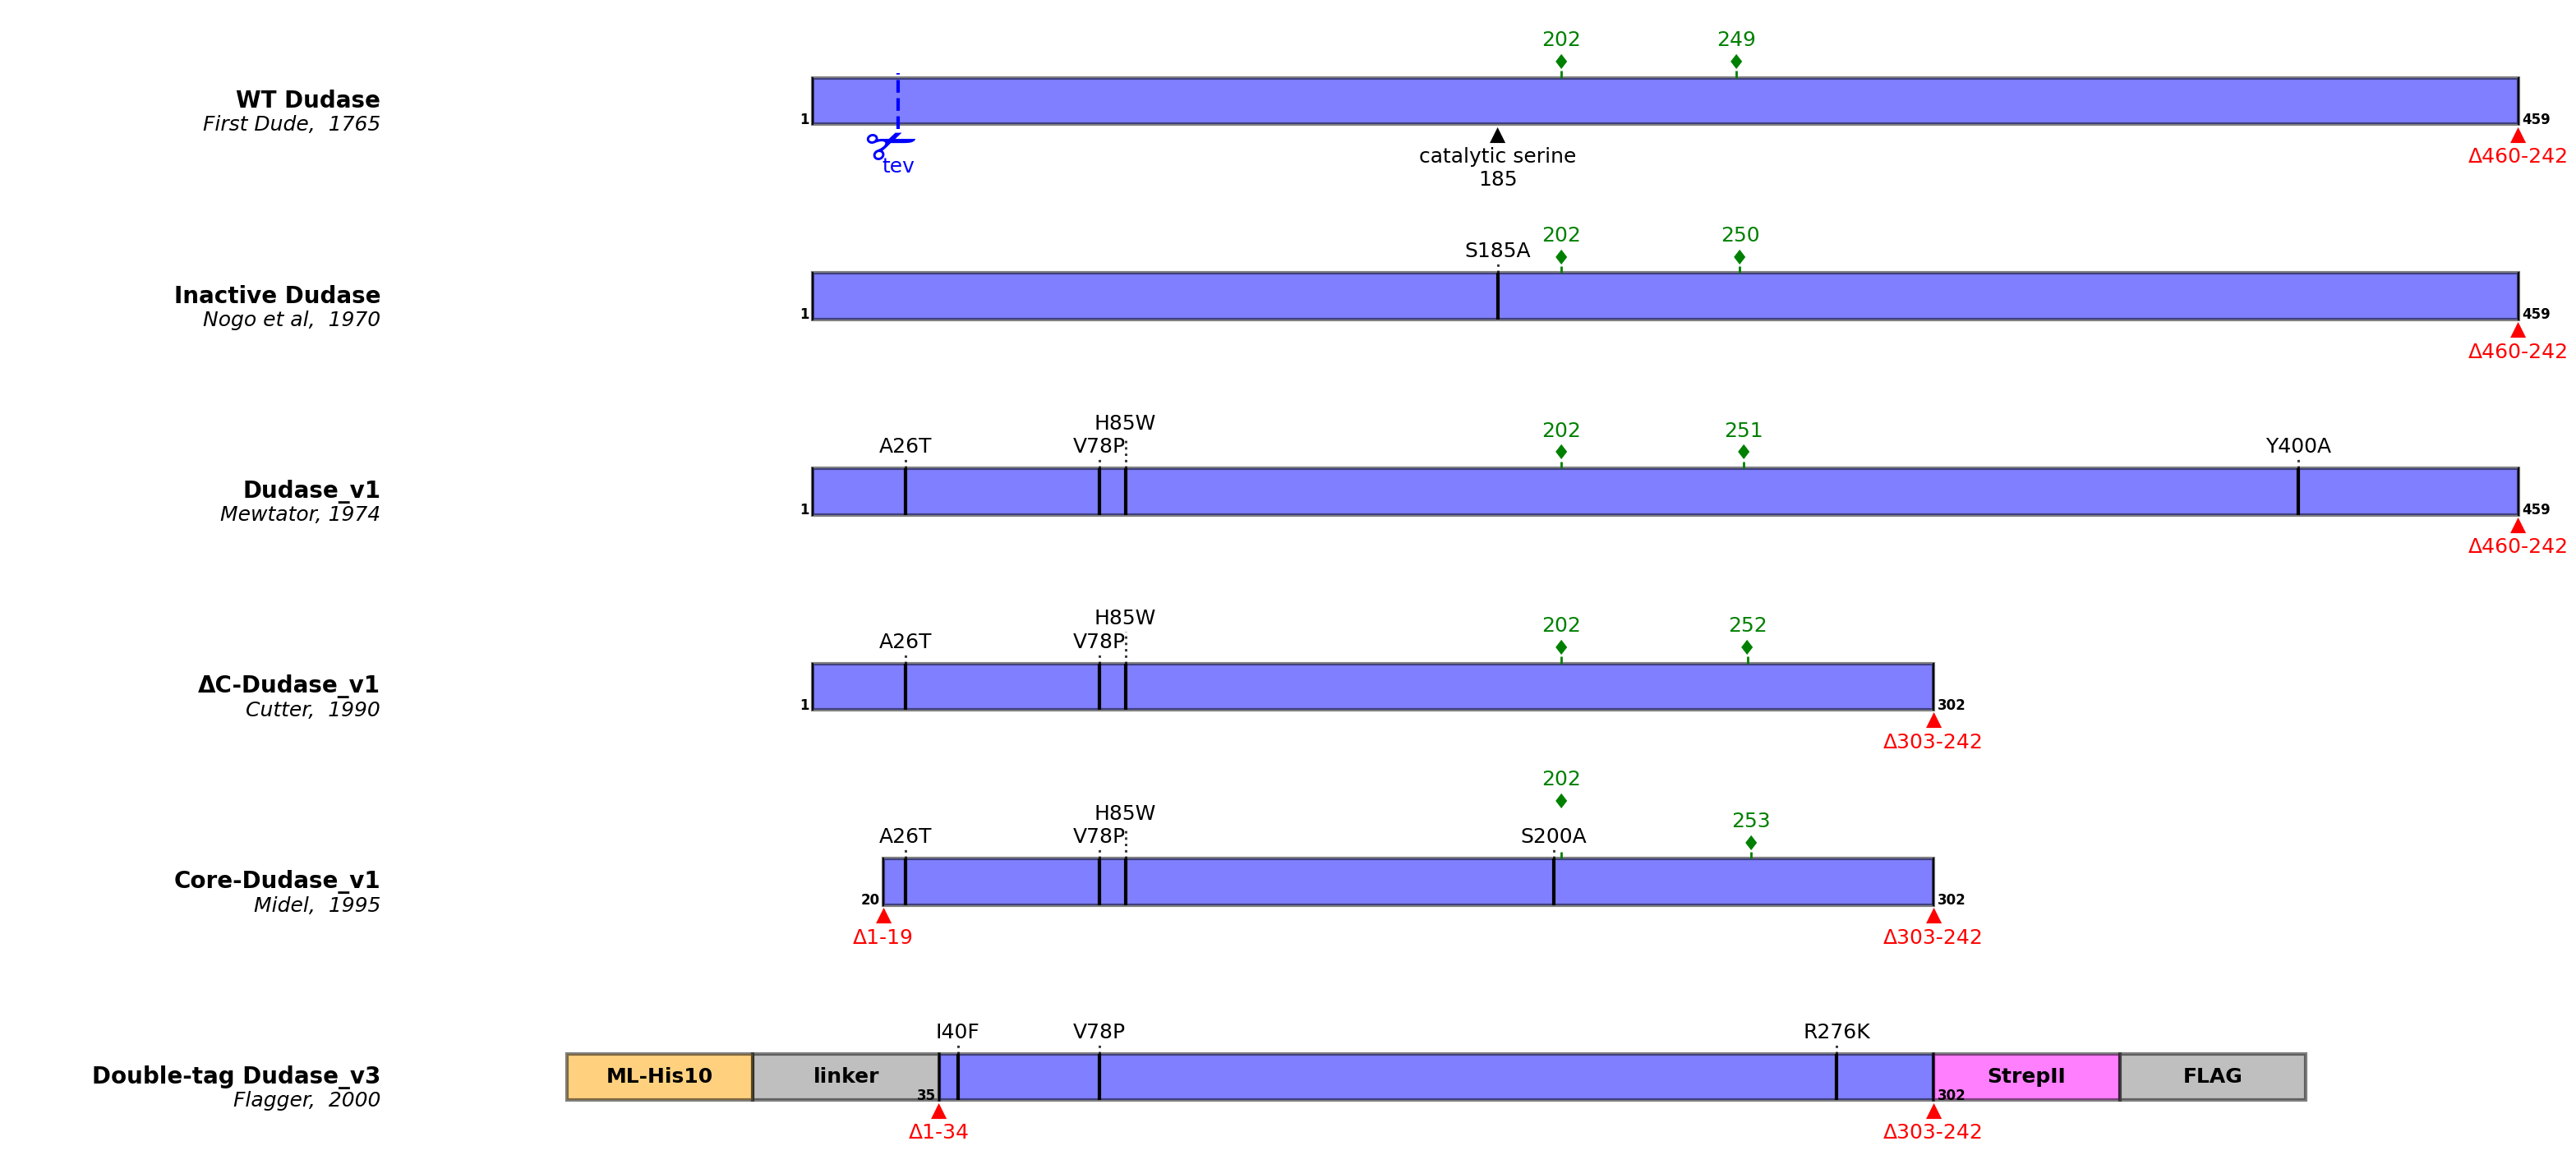

In [ ]:
# @title ## Make the figures
plotty(job_name,input_file)


In [ ]:
!zip -r output.zip output/
files.download('output.zip')

updating: output/ (stored 0%)
updating: output/example_input_plot_1.svg (deflated 87%)
updating: output/example_input_plot_1.png (deflated 31%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>